# Classifiez automatiquement des biens de consommation

- **Projet 6 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 1 : Classification de textes


<!--TABLE OF CONTENTS-->

- [1. Compréhension du problème](#1.-Compréhension-du-problème)
  - [1.1 Mission](#1.1-Mission)
  - [1.2 Requirements : Bibliothèques utilisées dans ce notebook](#1.2-Requirements-:-Bibliothèques-utilisées-dans-ce-notebook)
  - [1.3 Des fonctions utilitaires](#1.3-Des-fonctions-utilitaires)
  - [1.4 Des routines statistiques](#1.4-Des-routines-statistiques)
- [2. Import et nettoyage des données](#2.-Import-et-nettoyage-des-données)


# 1. Compréhension du problème

## 1.1 Mission

## Mission

Etudier la faisabilité d'un **moteur de classification** des articles en différentes catégories,
avec un niveau de précision suffisant.

- **réaliser une première étude de faisabilité d'un moteur de classification**, d'articles, basé sur
  une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

- **analyser le jeu de données** en **réalisant un prétraitement** des descriptions des produits et
  des images, une **réduction de dimension**, puis un **clustering**, à présenter sous la forme de
  graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories
  réelles et les clusters.
- illustre que les caractéristiques extraites permettent de regrouper des produits de même
  catégorie.

- démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des
  produits de même catégorie


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas',
                      'matplotlib', 'seaborn', 'scikit-learn',
                      'nltk==3.7',
                      'gensim==4.1.2',
                      'tensorflow==2.8.0'}
install_libraries(required_libraries)


missing libraries: {'gensim==4.1.2', 'nltk==3.7', 'tensorflow==2.8.0'}


### 1.2.1 Import des bibliothèques


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import gensim
import tensorflow as tf



### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; sklearn==1.0.2; nltk==3.7; gensim==4.1.2; tensorflow==2.8.0


### 1.2.3 Configuration défauts d'affichage


In [5]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 100)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [6]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/analyse'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [7]:
def to_png(fig_name=None) -> None:
    """
    Register the current plot figure as an image in a file.
    Must call plt.show() or show image (by calling to_png() as last row in python cell)
    to apply the call 'bbox_inches=tight', to be sure to include the whole title / legend
    in the plot area.
    """

    def get_title() -> str:
        """find current plot title (or suptitle if more than one plot)"""
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [8]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """
    Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


# 2. Import et nettoyage des données

## Les données

Un premier jeu de données d’articles avec la photo et une description associée :
[le lien pour télécharger](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip)


## Import des données

Le données du fichier zip (329 Mo) sont éxtraites dans le dossier définit par DATA_FOLDER ci-dessous.


In [9]:
ENV = 'local'

if ENV == 'local':
    # local development
    DATA_FOLDER = 'data/raw'
    OUT_FOLDER = 'data/out'
    IMAGE_FOLDER = 'images/textes'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC6'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC6'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC6/nettoyage'


In [10]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Dataset+projet+prétraitement+textes+images.zip'
RAW_DATA_FILENAME = 'Flipkart/flipkart_com-ecommerce_sample_1050.csv'


def os_make_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def os_path_join(folder, file):
    """remplacement pour `os.path.join(folder, file)` sur windows"""
    return f'{folder}/{file}'


os_make_dir(IMAGE_FOLDER)
RAW_DATA = os_path_join(DATA_FOLDER, RAW_DATA_FILENAME)
DATA_ZIPPED = os_path_join(DATA_FOLDER, ZIPPED_DATA_FILENAME)
print(f'data file: {RAW_DATA}')


data file: data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv


In [11]:
def unzip_data_si_besoin(env=ENV):
    """
    procedure pour unzip sur Google Drive via Google Colab
    """
    if os.path.exists(RAW_DATA):
        print(f'data CSV file exists ({RAW_DATA})')
    else:
        print(f'data CSV file does not exist ({RAW_DATA})')
        if env == 'colab' and os.path.exists(DATA_ZIPPED):
            # uncomment les 3 lignes suivants
            print(f'unzipping {DATA_ZIPPED}')
            !unzip {DATA_ZIPPED} - d {DATA_FOLDER}
            print(f'{DATA_ZIPPED} has been unzipped')
            if os.path.exists(RAW_DATA):
                print(f'data CSV file now exists ({RAW_DATA})')
        else:
            print(f'zipped data does not exist ({DATA_ZIPPED})')


unzip_data_si_besoin(ENV)


data CSV file exists (data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv)


In [12]:
def read_file_rows(file_path=RAW_DATA, nb_rows=1):
    fp = open(file_path, encoding='UTF-8')
    for i in range(nb_rows + 1):
        row = fp.readline()
        print(f'Line {i} :\n{row}')


read_file_rows(RAW_DATA, nb_rows=1)


Line 0 :
uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications

Line 1 :
55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with 

#### Format des données :

- La premiere ligne contient les en-têtes (column names)
- Les données semblent séparées par virgule
- On utilise `encoding = UTF-8`
- La colonne `product_specifications` est composé de key values.


In [13]:
df_data = pd.read_csv(RAW_DATA, sep=',', header=0, encoding='UTF-8')
df_data.head(2)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.00,899.00,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...",BTWEGFZHGBXPHZUH,600.00,449.00,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""val..."


### Nettoyage


In [14]:
df_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Il y a peu de données manquantes:

- 1 prix non-indiqué
- 75% des données n'ont pas de brand


### Catégories

L'objectif est de pouvoir classifier les produits dans le `product_category_tree` de façon automatique.


In [15]:
print(df_data['product_category_tree'].nunique())
print(df_data['product_category_tree'].str.lower().nunique())


642
639


Avec 1000 echantillons, il sera dificil d'automatiser la classification en 640 catégories.

On regard les niveaux plus haut de l'arbre.


In [16]:
def get_category_count(row):
    """obtenir le nombre de catégories pour un produit"""
    return row.count('[')


df_data['product_category_tree'].map(lambda x: get_category_count(x)).max()


1

Chaque produit est associe à seulement une categorie dans le category tree

La colonne `product_category_tree` est un arbre, separé par '>>'.

Quel est son profondeur ?


In [17]:
def get_depth(categorie: str) -> int:
    """obtenir le nombre de niveaux de catégories"""
    return len(categorie.split(' >> '))


df_data['product_category_tree'].map(lambda x: get_depth(x)).max()


7

Les produits ont jusqu'à 7 niveaux de catégorie


In [18]:

df_data['product_category_tree'].str.lstrip('["').str.split(' >>').head()


0    [Home Furnishing,  Curtains & Accessories,  Curtains,  Elegance Polyester Multicolor Abstract Ey...
1    [Baby Care,  Baby Bath & Skin,  Baby Bath Towels,  Sathiyas Baby Bath Towels,  Sathiyas Cotton B...
2    [Baby Care,  Baby Bath & Skin,  Baby Bath Towels,  Eurospa Baby Bath Towels,  Eurospa Cotton Ter...
3    [Home Furnishing,  Bed Linen,  Bedsheets,  SANTOSH ROYAL FASHION Bedsheets,  SANTOSH ROYAL FASHI...
4    [Home Furnishing,  Bed Linen,  Bedsheets,  Jaipur Print Bedsheets,  Jaipur Print Cotton Floral K...
Name: product_category_tree, dtype: object

In [19]:
def remove_brackets(node:str):
    node=node.replace('["','').replace('"]','')
    return node

def create_categ_level(df):
    df_cat = (df['product_category_tree']
                .map(lambda x:remove_brackets(x))
                .str.split(' >> ', expand=True))
    print(df_cat.shape)
    depth= len(df_cat.columns)
    df_cat.columns=[f'categ_level_{i}' for i in range(1,depth+1)]
    return pd.concat([df,df_cat], axis=1)
    # return df_cat

df_cleaned = df_data.pipe(create_categ_level)
    

(1050, 7)


### Categorie niveau 1


In [20]:
df_cleaned['categ_level_1'].value_counts()


Kitchen & Dining              150
Beauty and Personal Care      150
Home Furnishing               150
Baby Care                     150
Computers                     150
Home Decor & Festive Needs    150
Watches                       150
Name: categ_level_1, dtype: int64

On peux essayer de classifier par niveau 1


### Catégories - niveau 2


In [21]:
print(df_cleaned['categ_level_2'].nunique())
pd.concat([df_cleaned['categ_level_2'].value_counts().head(20),
           df_cleaned['categ_level_2'].value_counts(
).cumsum().head(20).rename('cum_sum'),
], axis=1)


62


,categ_level_2,cum_sum
Wrist Watches,149,149
Laptop Accessories,87,236
Infant Wear,84,320
Coffee Mugs,74,394
Showpieces,71,465
Bed Linen,65,530
Fragrances,65,595
Network Components,49,644
Cookware,27,671
Table Decor & Handicrafts,27,698


Pour l'arbre de categories, 90% des produits sont dans les 20 plus grands catégories de niveau 2.

- On peut evaluer la performance de classification à niveau 2


## Préparation des déscriptions des données

L'objectif est d'utiliser les déscriptions des données pour classifier dans les catégories de niveaux 1, 2, 3...

Il faut préparer les déscriptions:

- mettre tout en minuscule
- retire les mots de liaison,
- retirer la ponctuation

On utilise la librairie nltk (Natural Language Toolkit), pour aider la nettoyage


### Nettoyage du texte

#### Import des librairies


In [22]:
import nltk

# stopwords
nltk.download('stopwords')
# punctuation
nltk.download('punkt')
# lemmatization
nltk.download('wordnet')
# Open Multilingual Wordnet Project lemmatizations
nltk.download('omw-1.4')
pass


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Tokenization


In [23]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize


def tokenizer_fct(sentence):
    # print(sentence)
    sentence_clean = (sentence
                      .replace('-', ' ')
                      .replace('+', ' ')
                      .replace('/', ' ')
                      .replace('.', '. ')
                      .replace('#', ' '))
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens


print(tokenizer_fct(df_data['description'][6]))


['Camerii', 'WM64', 'Elegance', 'Analog', 'Watch', 'For', 'Men', ',', 'Boys', 'Buy', 'Camerii', 'WM64', 'Elegance', 'Analog', 'Watch', 'For', 'Men', ',', 'Boys', 'WM64', 'Online', 'at', 'Rs', '.', '449', 'in', 'India', 'Only', 'at', 'Flipkart', '.', 'com', '.', 'Great', 'Discounts', ',', 'Only', 'Genuine', 'Products', ',', '30', 'Day', 'Replacement', 'Guarantee', ',', 'Free', 'Shipping', '.', 'Cash', 'On', 'Delivery', '!']


### Stop words


In [24]:
from typing import List
from nltk.corpus import stopwords

stop_w = list(set(stopwords.words('english'))) + \
    ['[', ']', ',', '.', ':', '?', '(', ')']


def stop_word_filter_fct(list_words: List[str]) -> List[str]:
    """Stop words"""
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2


print(stop_word_filter_fct(tokenizer_fct(df_data['description'][6])))


['Camerii', 'WM64', 'Elegance', 'Analog', 'Watch', 'For', 'Men', 'Boys', 'Buy', 'Camerii', 'WM64', 'Elegance', 'Analog', 'Watch', 'For', 'Men', 'Boys', 'WM64', 'Online', '449', 'India', 'Only', 'Flipkart', 'com', 'Great', 'Discounts', 'Only', 'Genuine', 'Products', 'Day', 'Replacement', 'Guarantee', 'Free', 'Shipping', 'Cash', 'Delivery']


In [25]:
print(stop_word_filter_fct(tokenizer_fct(df_data['description'][6])))


['Camerii', 'WM64', 'Elegance', 'Analog', 'Watch', 'For', 'Men', 'Boys', 'Buy', 'Camerii', 'WM64', 'Elegance', 'Analog', 'Watch', 'For', 'Men', 'Boys', 'WM64', 'Online', '449', 'India', 'Only', 'Flipkart', 'com', 'Great', 'Discounts', 'Only', 'Genuine', 'Products', 'Day', 'Replacement', 'Guarantee', 'Free', 'Shipping', 'Cash', 'Delivery']


In [26]:
from typing import List


def lower_start_fct(list_words: List[str]) -> List[str]:
    """lower case et alpha"""
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
          #                                   and (not w.startswith("#"))
          and (not w.startswith("http"))]
    return lw


print(lower_start_fct(stop_word_filter_fct(
    tokenizer_fct(df_data['description'][6]))))


['camerii', 'wm64', 'elegance', 'analog', 'watch', 'for', 'men', 'boys', 'buy', 'camerii', 'wm64', 'elegance', 'analog', 'watch', 'for', 'men', 'boys', 'wm64', 'online', '449', 'india', 'only', 'flipkart', 'com', 'great', 'discounts', 'only', 'genuine', 'products', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'delivery']


In [27]:
from typing import List
from nltk.stem import WordNetLemmatizer


def lemma_fct(list_words: List[str]) -> List[str]:
    """
    Lemmatizer (base d'un mot)
    """
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


In [28]:
# test de lemmatizer
print(lemma_fct(lower_start_fct(
    stop_word_filter_fct(tokenizer_fct(df_data['description'][6])))))


['camerii', 'wm64', 'elegance', 'analog', 'watch', 'for', 'men', 'boy', 'buy', 'camerii', 'wm64', 'elegance', 'analog', 'watch', 'for', 'men', 'boy', 'wm64', 'online', '449', 'india', 'only', 'flipkart', 'com', 'great', 'discount', 'only', 'genuine', 'product', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'delivery']


# Préparation commune des traitements


In [29]:
from nltk.tokenize import sent_tokenize, word_tokenize



def transform_bow_fct(desc_text):
    """
    Fonction de préparation du texte pour le bag of words
    (Countvectorizer et Tf_idf, Word2Vec)
    """
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


def transform_bow_lem_fct(desc_text):
    """
    Fonction de préparation du texte pour le bag of words 
    avec lemmatization
    """
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


def transform_dl_fct(desc_text):
    """
    Fonction de préparation du texte pour le Deep learning 
    (USE et BERT)
    """
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


In [30]:

def transform_field(df: pd.DataFrame, text_col: str = 'description'):
    df = df.copy()
    df['sentence_bow'] = df[text_col].apply(lambda x: transform_bow_fct(x))
    df['sentence_bow_lem'] = df[text_col].apply(
        lambda x: transform_bow_lem_fct(x))
    df['sentence_dl'] = df[text_col].apply(lambda x: transform_dl_fct(x))
    print(f'transform_field [{text_col}], df.shape={df.shape}')
    return df


df_cleaned.pipe(transform_field).head(1)


transform_field [description], df.shape=(1050, 25)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categ_level_1,categ_level_2,categ_level_3,categ_level_4,categ_level_5,categ_level_6,categ_level_7,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.00,899.00,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do...,None,None,None,key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance ...,key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance p...,"key features of elegance polyester multicolor abstract eyelet door curtain floral curtain , eleg..."


In [31]:

def calc_length_bow(df: pd.DataFrame):
    df = df.copy()
    df['length_bow'] = df['sentence_bow'].apply(
        lambda x: len(word_tokenize(x)))
    print(f"max length bow : {df['length_bow'].max()}")
    df['length_dl'] = df['sentence_dl'].apply(lambda x: len(word_tokenize(x)))
    print(f"max length dl : {df['length_dl'].max()}")
    return df


df_cleaned = (
    pd.read_csv(RAW_DATA, sep=',', encoding='UTF-8')
    .pipe(create_categ_level)
    .pipe(transform_field, 'description')
    .pipe(calc_length_bow))

df_cleaned.head(1)


(1050, 7)
transform_field [description], df.shape=(1050, 25)
max length bow : 377
max length dl : 636


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categ_level_1,categ_level_2,categ_level_3,categ_level_4,categ_level_5,categ_level_6,categ_level_7,sentence_bow,sentence_bow_lem,sentence_dl,length_bow,length_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.00,899.00,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do...,None,None,None,key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance ...,key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance p...,"key features of elegance polyester multicolor abstract eyelet door curtain floral curtain , eleg...",158,258


### Enregistre les données préparées

In [32]:
os_make_dir(OUT_FOLDER)
df_cleaned.to_csv(f'{OUT_FOLDER}/data_cleaned.csv',encoding='UTF-8', index=False)

## Lecture dataset

In [33]:
data_T =  pd.read_csv(f'{OUT_FOLDER}/data_cleaned.csv')
print(data_T.shape)

(1050, 27)


In [34]:
l_cat=list(set(data_T['categ_level_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['categ_level_1'])) for i in range(len(data_T))]

catégories :  ['Watches', 'Baby Care', 'Kitchen & Dining', 'Home Furnishing', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Computers']


## Fonctions communes

In [35]:
from sklearn import manifold, cluster, metrics
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def ARI_fct(features):
    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_



In [36]:

# 
def TSNE_visu_fct(X_tsne_, y_cat_num_, labels_, ARI_,l_cat_=l_cat,
                bbox_left=-0.05, loc=1,
                  titre1='Représentation des produits par catégories réelles',
                  titre2='Représentation des produits par clusters'):
    """visualisation du Tsne selon les vraies catégories et selon les clusters"""
    fig = plt.figure(figsize=(15, 6))

    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(X_tsne_[:, 0], X_tsne_[:, 1], c=y_cat_num_, cmap='Set1')
    ax1.legend(handles=scatter.legend_elements()[
               0], labels=l_cat_,  bbox_to_anchor=(bbox_left, 0.5), 
               loc=loc, title="Categorie")
               
    plt.title(titre1)

    ax2 = fig.add_subplot(122)
    scatter = ax2.scatter(X_tsne_[:, 0], X_tsne_[:, 1], c=labels_, cmap='Set1')
    ax2.legend(handles=scatter.legend_elements()[0], labels=set(
        labels_), loc="best", title="Clusters")
    plt.title(titre2)
    print("ARI : ", ARI_)
    return fig



# Bag of word - Tf-idf

## Préparation sentences

In [37]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

## Exécution des modèles

In [38]:
print("CountVectorizer : ")
print("-----------------")
ARI1, X_tsne1, labels1 = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI2, X_tsne2, labels2 = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.3848 time :  20.0

Tf-idf : 
--------
ARI :  0.5449 time :  21.0


## Graphiques

ARI :  0.3848
"Bag-of-Words_(CountVectorizer),_ARI_=_0-385.png"


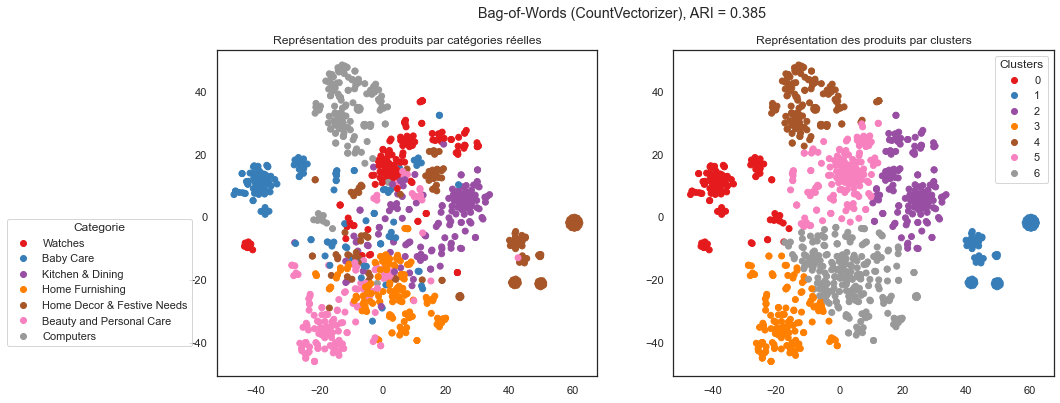

In [39]:
fig = TSNE_visu_fct(X_tsne1, y_cat_num, labels1, ARI1)
plt.suptitle(f'Bag-of-Words (CountVectorizer), ARI = {ARI1:.3f}')
to_png()

ARI :  0.5449
"Bag-of-Words_(TF-IDF),_ARI_=_0-545.png"


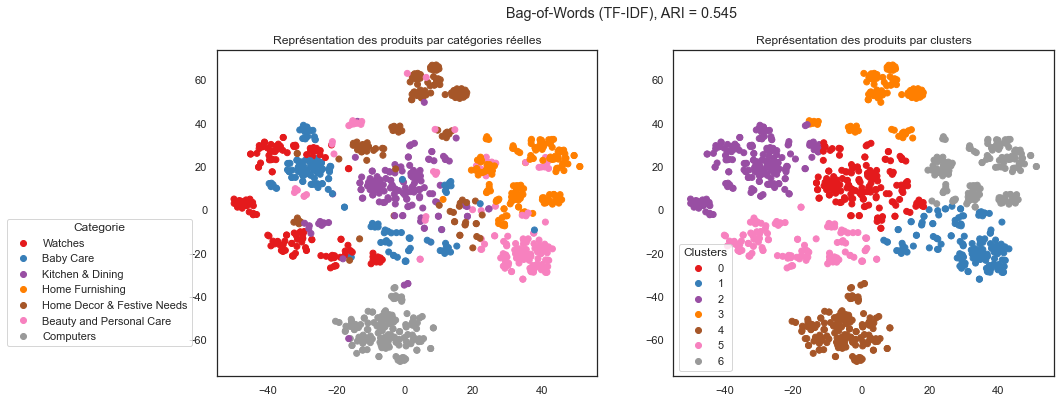

In [40]:
fig = TSNE_visu_fct(X_tsne2, y_cat_num, labels2, ARI2)
plt.suptitle(f'Bag-of-Words (TF-IDF), ARI = {ARI2:.3f}')
to_png()

# Word2Vec

In [41]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics

from tensorflow.keras.models import Model
# for Word2Vec
import gensim

## Création du modèle Word2Vec

In [42]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [43]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4688
Word2Vec trained


### Préparation des sentences (tokenization)

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4689


## Création de la matrice d'embedding

In [45]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4689, 300)


## Création du modèle d'embedding

In [46]:
# Création du modèle
from tensorflow.keras import layers as klayers

input=klayers.Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=klayers.Input(shape=(maxlen,),dtype='float64')  
word_embedding=klayers.Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=klayers.GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1406700   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,406,700
Trainable params: 1,406,700
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [47]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(1050, 300)

In [48]:
ARI3, X_tsne3, labels3 = ARI_fct(embeddings)

ARI :  0.2153 time :  17.0


ARI :  0.2153
"Word2Vec,_ARI_=_0-215.png"


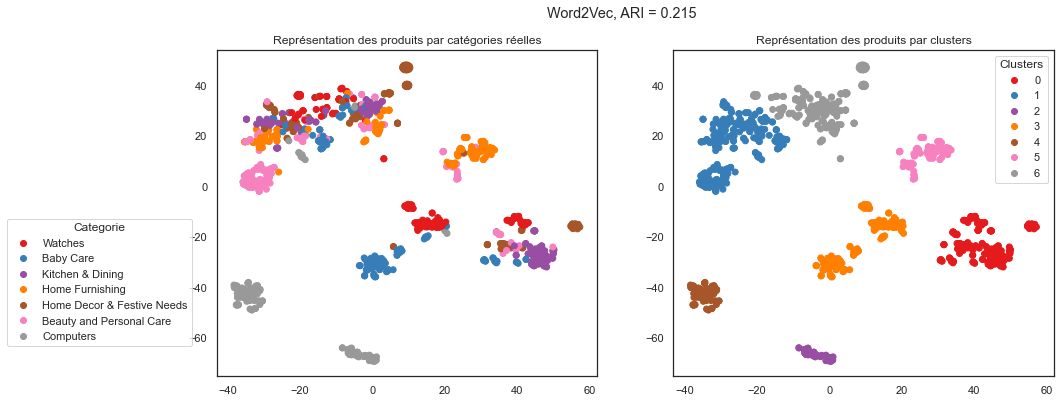

In [49]:
fig=TSNE_visu_fct(X_tsne3, y_cat_num, labels3, ARI3)
plt.suptitle(f'Word2Vec, ARI = {ARI3:.3f}')
to_png()

# BERT

In [50]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
print (tensorflow.keras.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers 
from transformers import TFBertModel, AutoTokenizer, TFAutoModel
# from transformers import *

os.environ["TF_KERAS"]='1'

2.8.0


In [51]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.8.0
2.8.0
Num GPUs Available:  0
True


## Fonctions communes

In [52]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'
- Downloads 511 Mb pretrained model

In [53]:
from transformers import TFAutoModel
model = TFAutoModel.from_pretrained('bert-base-uncased')

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are in

In [54]:
# Création des features
# downloads bert features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

temps traitement :  126.0


In [55]:
ARI4, X_tsne4, labels4 = ARI_fct(features_bert)

ARI :  0.3269 time :  17.0


ARI :  0.3269
"BERT_HuggingFace,_ARI_=_0-327.png"


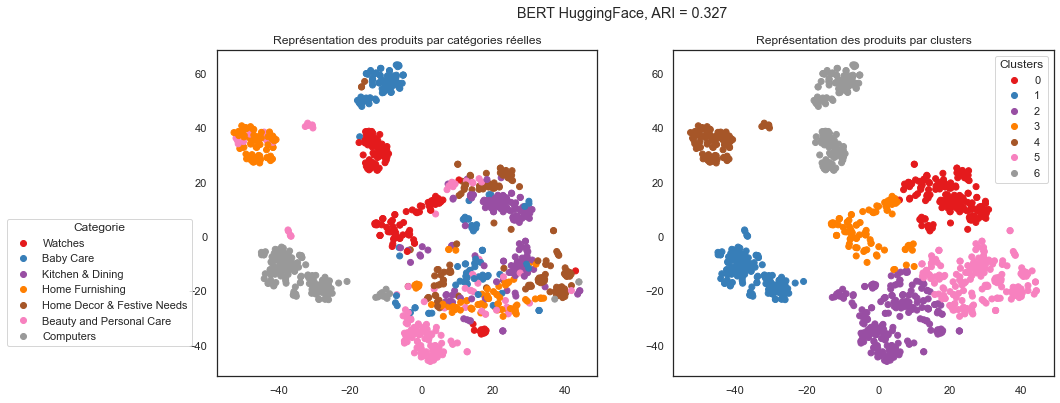

In [56]:
TSNE_visu_fct(X_tsne4, y_cat_num, labels4, ARI4)
plt.suptitle(f'BERT HuggingFace, ARI = {ARI4:.3f}')
to_png()